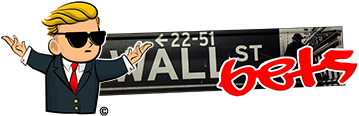

# Common 

## Dependencies

In [ ]:
! pip install PyYAML
! pip install yolov5
! pip install vaderSentiment
! pip install pandas-profiling[notebook] --upgrade
! pip install contractions
! pip install keras-ocr
! pip install CatBoost
! pip install prophet

## Imports

In [ ]:
import pandas as pd
from google.colab import drive
from pandas_profiling import ProfileReport
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import date, datetime
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
import pytz
import urllib.request
import glob
import os
import keras_ocr
import time
import torch
import base64
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.inspection import *

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from prophet import Prophet

import cv2
import pickle

%matplotlib inline

nltk.download('stopwords')


## Pre-analysis

### Read data

In [ ]:
def load_df():
  df = pd.read_csv('reddit_wsb_new.csv')
  df = df[["title", "score", "id", "url", "comms_num", "created", "body", "timestamp", "upvote_ratio"]]
  return df

In [ ]:
df = pd.read_csv('reddit_wsb_new.csv')

df = df[["title", "score", "id", "url", "comms_num", "created", "body", "timestamp", "upvote_ratio"]]

df.head(3)

title  ...  upvote_ratio
0  Due to all the manipulation happening on sever...  ...          0.75
1   Holding GME till the squeeze has squoze. 6421@21  ...          0.99
2                              Going long on my dick  ...          0.39

[3 rows x 9 columns]

## Data preprocessing

In [ ]:
df = load_df()

# Replace NaN body with empty string
df.body.fillna(value="", inplace=True)

df.to_csv('cleaned.csv', index=False) 

df.head(2)

title  ...  upvote_ratio
0  Due to all the manipulation happening on sever...  ...          0.75
1   Holding GME till the squeeze has squoze. 6421@21  ...          0.99

[2 rows x 9 columns]

## Modify timezone

In [ ]:
df = pd.read_csv('cleaned.csv', na_filter=False)

# compare timestamp with created
def timestamp_unix(row):
  return pytz.timezone("Etc/GMT-9").localize(datetime.utcfromtimestamp(int(row.created)))

df["timestamp_unix"] = df.apply(lambda row: timestamp_unix(row), axis=1)

In [ ]:
# sorting by date there's also this one suspicious entry from 2020 that is actually a deleted post
df.sort_values(by=['timestamp_unix'], ascending=True).head(2)


title  ...            timestamp_unix
27381  Daily Discussion Thread for January 19, 2021  ... 2021-01-19 11:00:21+09:00
11353     Check out my New Strategy based on Volume  ... 2021-01-19 11:05:42+09:00

[2 rows x 10 columns]

In [ ]:
lower_bound = pytz.timezone("Etc/GMT-9").localize(datetime(2021, 1, 20))
upper_bound = pytz.timezone("Etc/GMT-9").localize(datetime(2021, 2, 11))
df[~df["timestamp_unix"].between(lower_bound,upper_bound)].sort_values(by=['timestamp_unix'], ascending=True)

title  ...            timestamp_unix
27381       Daily Discussion Thread for January 19, 2021  ... 2021-01-19 11:00:21+09:00
11353          Check out my New Strategy based on Volume  ... 2021-01-19 11:05:42+09:00
2798   For all the autists bored af the past few days...  ... 2021-01-19 11:16:33+09:00
33329                       BB vs GME technical analysis  ... 2021-01-19 11:32:49+09:00
16202                                       Tendieman v3  ... 2021-01-19 11:41:18+09:00
...                                                  ...  ...                       ...
26908  I see a no meme mode, can we get a only meme m...  ... 2021-02-11 09:17:58+09:00
25240                    While the weed meta continues..  ... 2021-02-11 09:32:23+09:00
31099                      ARCHER (eVTOL) will go public  ... 2021-02-11 09:51:35+09:00
28981        Thoughts on $CME - potentially undervalued?  ... 2021-02-11 09:51:37+09:00
36651     There's only room for one "APE" in this Town 🦍  ... 2021-02-11 10:02:43+09:00

[276 rows x 10 columns]

In [ ]:
df = df[df["timestamp_unix"].between(lower_bound,upper_bound)]
df.head(2)

title  ...            timestamp_unix
0  Due to all the manipulation happening on sever...  ... 2021-01-27 17:18:38+09:00
1   Holding GME till the squeeze has squoze. 6421@21  ... 2021-01-29 23:12:20+09:00

[2 rows x 10 columns]

In [ ]:
# this example link (index 0 in the df.head)
# https://www.reddit.com/r/wallstreetbets/comments/l6ulcx/its_not_about_the_money_its_about_sending_a/
# shows 12:37:41 for GMT+1 timezone, thus GMT+8 is correct (not the 21:37:41 from the timestamp)

# Drop useless columns
df.drop(columns=['created', 'timestamp'], inplace=True)

df.to_csv('with_changed_timestamp_zone.csv', index=False) 

df.head(2)